Aperçu des données d'achat:
                           order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id   price  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   58.90   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36  239.90   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d  199.00   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   12.99   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87  199.90   

   freight_value      shipping_limit     limit  name_lenght  \
0          13.29 2017-09-19 09:45:35  0.775833         58.0   
1          19.93 2017-05-03 11:05:

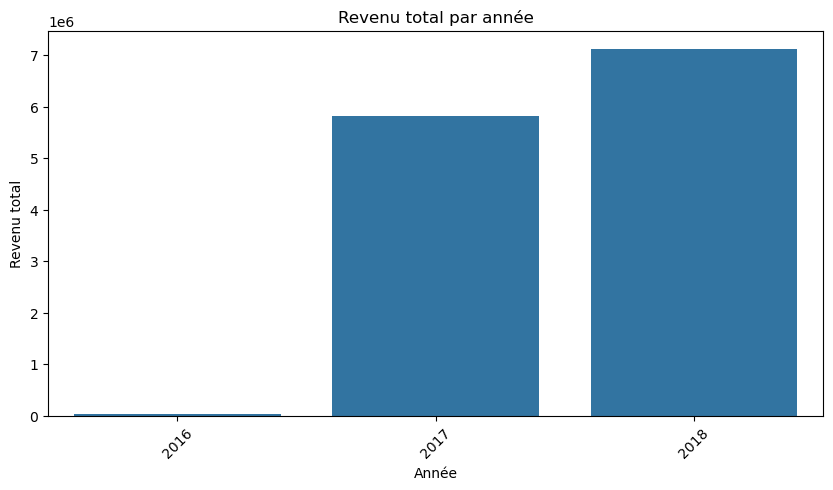

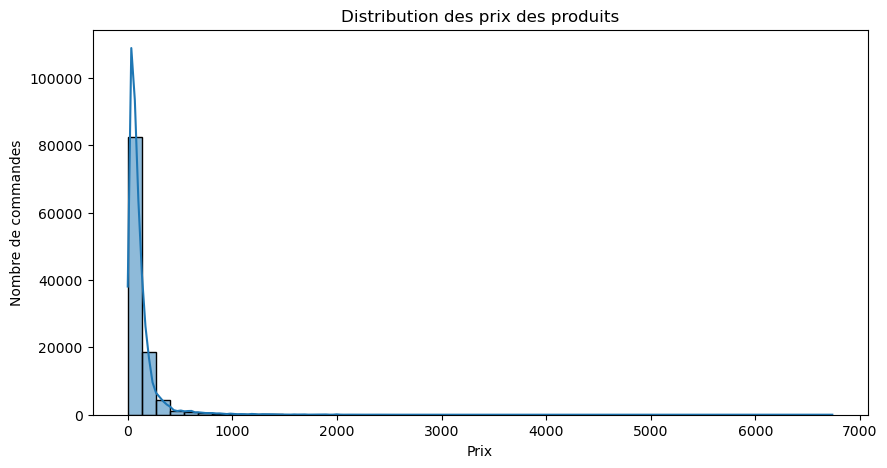

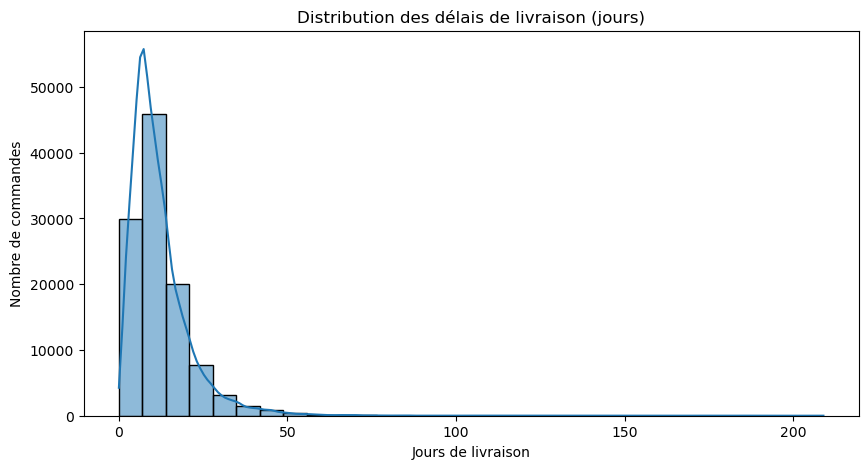

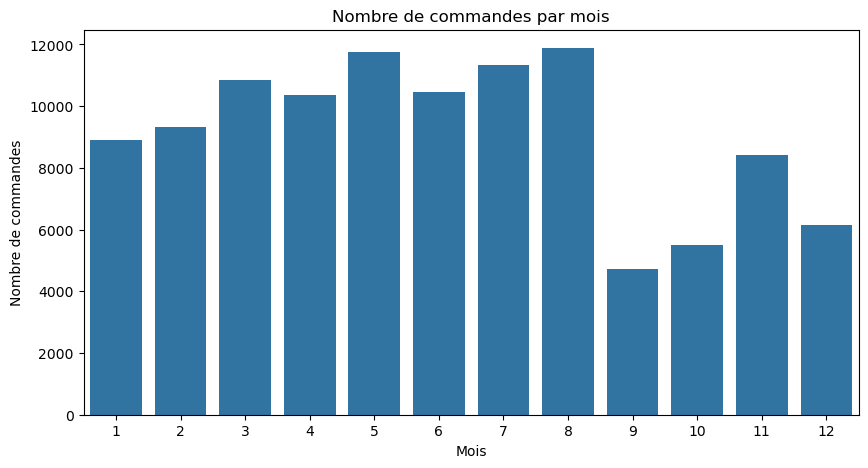

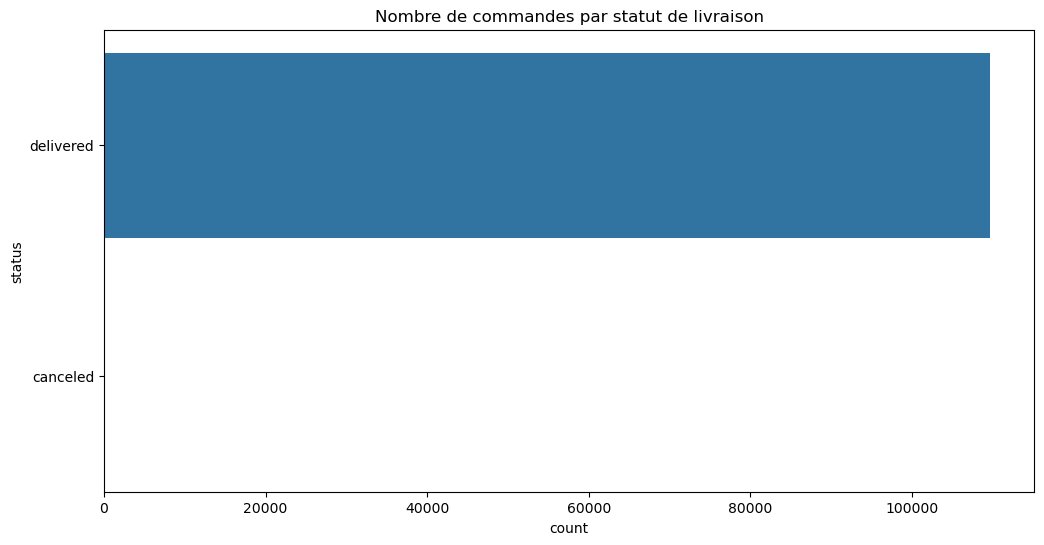

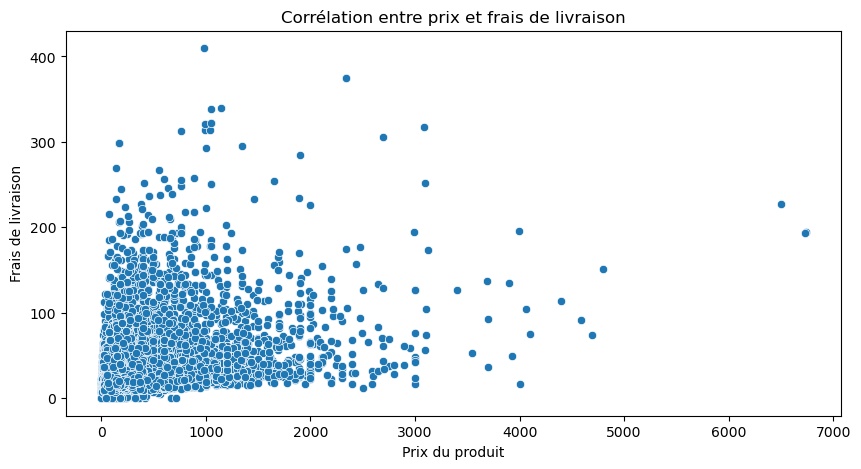

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Charger les fichiers Parquet
achat_df = pd.read_parquet('analyse_achat.parquet')
ventes_df = pd.read_parquet('analyse_ventes.parquet')

# Afficher un aperçu des données
print("Aperçu des données d'achat:")
print(achat_df.head(), "\n")

print("Aperçu des données de vente:")
print(ventes_df.head(), "\n")

# Nettoyage des données (suppression des valeurs manquantes)
achat_df.dropna(inplace=True)
ventes_df.dropna(inplace=True)

# Conversion des dates
ventes_df['purchase_timestamp'] = pd.to_datetime(ventes_df['purchase_timestamp'])

# Fusion des données si possible
if 'order_id' in ventes_df.columns and 'order_id' in achat_df.columns:
    ventes_df = ventes_df.merge(achat_df[['order_id', 'price', 'freight_value']], on='order_id', how='left')

# Création des dimensions temporelles
ventes_df['année'] = ventes_df['purchase_timestamp'].dt.year
ventes_df['mois'] = ventes_df['purchase_timestamp'].dt.month
ventes_df['jour'] = ventes_df['purchase_timestamp'].dt.day

# Remplacement des valeurs manquantes après fusion
ventes_df.fillna({'price': 0, 'freight_value': 0}, inplace=True)

# Création d'une colonne pour le revenu total
if 'revenu_total' not in ventes_df.columns:
    ventes_df['revenu_total'] = ventes_df['price']

# **1. Revenu total par année**
plt.figure(figsize=(10, 5))
sns.barplot(x='année', y='revenu_total', data=ventes_df, estimator=sum, errorbar=None)
plt.title("Revenu total par année")
plt.xlabel("Année")
plt.ylabel("Revenu total")
plt.xticks(rotation=45)
plt.show()

# **2. Nombre de ventes par catégorie de produit**
if 'categorie_produit' in ventes_df.columns:
    plt.figure(figsize=(12, 6))
    sns.countplot(y='categorie_produit', data=ventes_df, order=ventes_df['categorie_produit'].value_counts().index)
    plt.title("Nombre de ventes par catégorie de produit")
    plt.show()

#  **3. Répartition des commandes par état du client**
if 'cust_state' in ventes_df.columns:
    plt.figure(figsize=(12, 6))
    sns.countplot(x='cust_state', data=ventes_df, order=ventes_df['cust_state'].value_counts().index)
    plt.title("Répartition des commandes par état du client")
    plt.xticks(rotation=45)
    plt.show()

# **4. Répartition des commandes par état du vendeur**
if 'sell_state' in ventes_df.columns:
    plt.figure(figsize=(12, 6))
    sns.countplot(x='sell_state', data=ventes_df, order=ventes_df['sell_state'].value_counts().index)
    plt.title("Répartition des commandes par état du vendeur")
    plt.xticks(rotation=45)
    plt.show()

# **5. Distribution des prix des produits**
plt.figure(figsize=(10, 5))
sns.histplot(ventes_df['price'], bins=50, kde=True)
plt.title("Distribution des prix des produits")
plt.xlabel("Prix")
plt.ylabel("Nombre de commandes")
plt.show()

# **6. Distribution des délais de livraison (jours)**
if 'delivered_customer' in ventes_df.columns:
    ventes_df['delivery_time'] = (ventes_df['delivered_customer'] - ventes_df['purchase_timestamp']).dt.days
    plt.figure(figsize=(10, 5))
    sns.histplot(ventes_df['delivery_time'].dropna(), bins=30, kde=True)
    plt.title("Distribution des délais de livraison (jours)")
    plt.xlabel("Jours de livraison")
    plt.ylabel("Nombre de commandes")
    plt.show()

# **7. Moyenne des frais de port par état**
if 'cust_state' in ventes_df.columns:
    plt.figure(figsize=(12, 6))
    sns.barplot(x='cust_state', y='freight_value', data=ventes_df, estimator=sum, errorbar=None)
    plt.title("Moyenne des frais de port par état")
    plt.xticks(rotation=45)
    plt.show()

# **8. Répartition des commandes par mois**
plt.figure(figsize=(10, 5))
sns.countplot(x='mois', data=ventes_df, order=sorted(ventes_df['mois'].unique()))
plt.title("Nombre de commandes par mois")
plt.xlabel("Mois")
plt.ylabel("Nombre de commandes")
plt.show()

# **9. Nombre de commandes par statut de livraison**
if 'status' in ventes_df.columns:
    plt.figure(figsize=(12, 6))
    sns.countplot(y='status', data=ventes_df, order=ventes_df['status'].value_counts().index)
    plt.title("Nombre de commandes par statut de livraison")
    plt.show()

# **10. Corrélation entre le prix et les frais de livraison**
plt.figure(figsize=(10, 5))
sns.scatterplot(x='price', y='freight_value', data=ventes_df)
plt.title("Corrélation entre prix et frais de livraison")
plt.xlabel("Prix du produit")
plt.ylabel("Frais de livraison")
plt.show()


In [39]:


# Table des faits : Ventes
Faits_Ventes = ventes_df[['order_id', 'customer_id', 'purchase_timestamp', 'price', 'freight_value']].copy()

# Table des faits : Achats
Faits_Achats = achat_df[['order_id', 'product_id', 'seller_id', 'price', 'freight_value', 'shipping_limit']].copy()

# Dimension Temps
Dim_Temps = ventes_df[['purchase_timestamp']].drop_duplicates().copy()
Dim_Temps['date_id'] = Dim_Temps['purchase_timestamp']
Dim_Temps['année'] = Dim_Temps['purchase_timestamp'].dt.year
Dim_Temps['mois'] = Dim_Temps['purchase_timestamp'].dt.month
Dim_Temps['jour'] = Dim_Temps['purchase_timestamp'].dt.day
Dim_Temps['jour_semaine'] = Dim_Temps['purchase_timestamp'].dt.day_name()

# Dimension Produit
Dim_Produit = achat_df[['product_id', 'name_lenght', 'description_lenght']].drop_duplicates().copy()
Dim_Produit.rename(columns={'name_lenght': 'longueur_nom', 'description_lenght': 'longueur_description'}, inplace=True)

# Dimension Client
Dim_Client = ventes_df[['customer_id', 'state', 'city', 'lat', 'lng']].drop_duplicates().copy()
Dim_Client.rename(columns={'state': 'cust_state', 'city': 'cust_city', 'lat': 'cust_lat', 'lng': 'cust_lng'}, inplace=True)

# Dimension Vendeur
Dim_Vendeur = achat_df[['seller_id', 'sell_state', 'sell_city', 'sell_lat', 'sell_lng']].drop_duplicates().copy()

# Dimension Livraison
Dim_Livraison = ventes_df[['order_id', 'status', 'delivered_customer', 'purchase_timestamp', 'freight_value']].copy()
Dim_Livraison['delivery_time'] = (Dim_Livraison['delivered_customer'] - Dim_Livraison['purchase_timestamp']).dt.days

# Affichage des résultats
print("Table des Faits - Ventes:")
print(Faits_Ventes.head(), "\n")

print("Table des Faits - Achats:")
print(Faits_Achats.head(), "\n")

print("Dimension Temps:")
print(Dim_Temps.head(), "\n")

print("Dimension Produit:")
print(Dim_Produit.head(), "\n")

print("Dimension Client:")
print(Dim_Client.head(), "\n")

print("Dimension Vendeur:")
print(Dim_Vendeur.head(), "\n")

print("Dimension Livraison:")
print(Dim_Livraison.head(), "\n")


Table des Faits - Ventes:
                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

   purchase_timestamp   price  freight_value  
0 2017-10-02 10:56:33   29.99           8.72  
1 2018-07-24 20:41:37  118.70          22.76  
2 2018-08-08 08:38:49  159.90          19.22  
3 2017-11-18 19:28:06   45.00          27.20  
4 2018-02-13 21:18:39   19.90           8.72   

Table des Faits - Achats:
                           order_id                        product_id  \
0  00010242fe8c5a6d1ba2dd792cb16214  4244733e06e7ecb4970a6e2683c13e61   
1  00018f77f2f0320c557190d7a144bdd3  e5f2d52b802189ee658865ca93d83a8f   
2  000

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Charger les fichiers Parquet avec gestion des erreurs
def load_parquet(file_path):
    try:
        return pd.read_parquet(file_path)
    except Exception as e:
        print(f"Erreur lors du chargement de {file_path}: {e}")
        return None

achat_df = load_parquet('analyse_achat.parquet')
ventes_df = load_parquet('analyse_ventes.parquet')

if achat_df is None or ventes_df is None:
    raise SystemExit("Impossible de charger les fichiers Parquet.")

# Nettoyage des données
achat_df.dropna(inplace=True)
ventes_df.dropna(inplace=True)

# Conversion des dates
for date_col in ['purchase_timestamp', 'delivered_customer', 'shipping_limit']:
    if date_col in ventes_df.columns:
        ventes_df[date_col] = pd.to_datetime(ventes_df[date_col], errors='coerce')

# Fusion des données
if 'order_id' in ventes_df.columns and 'order_id' in achat_df.columns:
    ventes_df = ventes_df.merge(
        achat_df[['order_id', 'price', 'freight_value']],
        on='order_id', how='left'
    )

# Création des dimensions temporelles
ventes_df['année'] = ventes_df['purchase_timestamp'].dt.year
ventes_df['mois'] = ventes_df['purchase_timestamp'].dt.month
ventes_df['jour'] = ventes_df['purchase_timestamp'].dt.day

achat_df['année'] = achat_df['shipping_limit'].dt.year
achat_df['mois'] = achat_df['shipping_limit'].dt.month
achat_df['jour'] = achat_df['shipping_limit'].dt.day


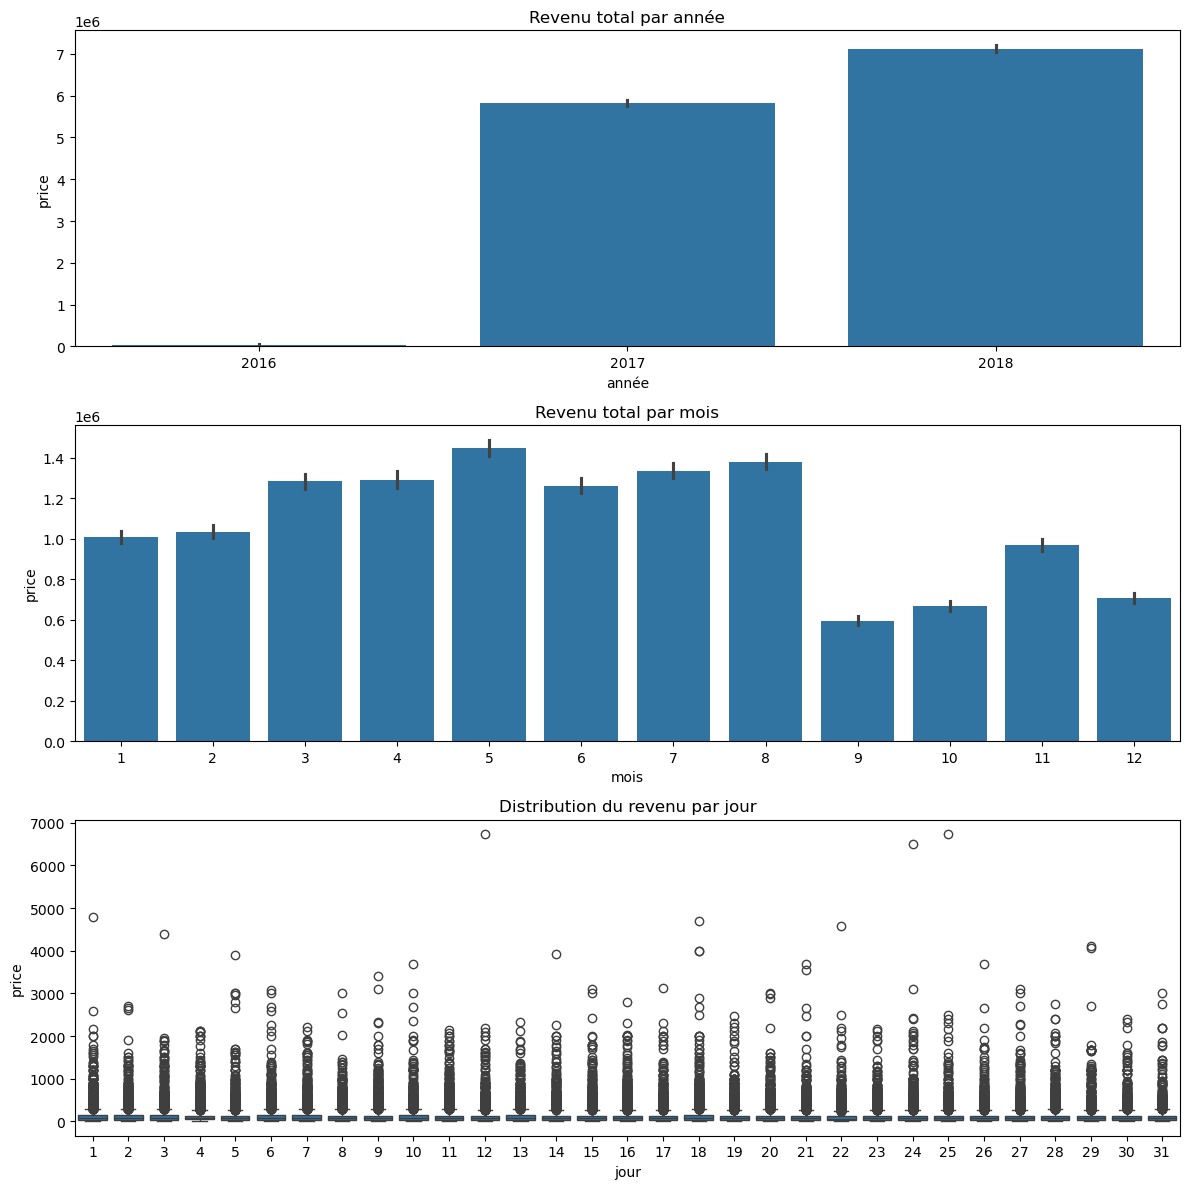

In [59]:
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

# Revenu par année
sns.barplot(x='année', y='price', data=ventes_df, estimator=sum, ax=axes[0])
axes[0].set_title("Revenu total par année")

# Revenu par mois
sns.barplot(x='mois', y='price', data=ventes_df, estimator=sum, ax=axes[1])
axes[1].set_title("Revenu total par mois")

# Revenu par jour
sns.boxplot(x='jour', y='price', data=ventes_df, ax=axes[2])
axes[2].set_title("Distribution du revenu par jour")

plt.tight_layout()
plt.show()


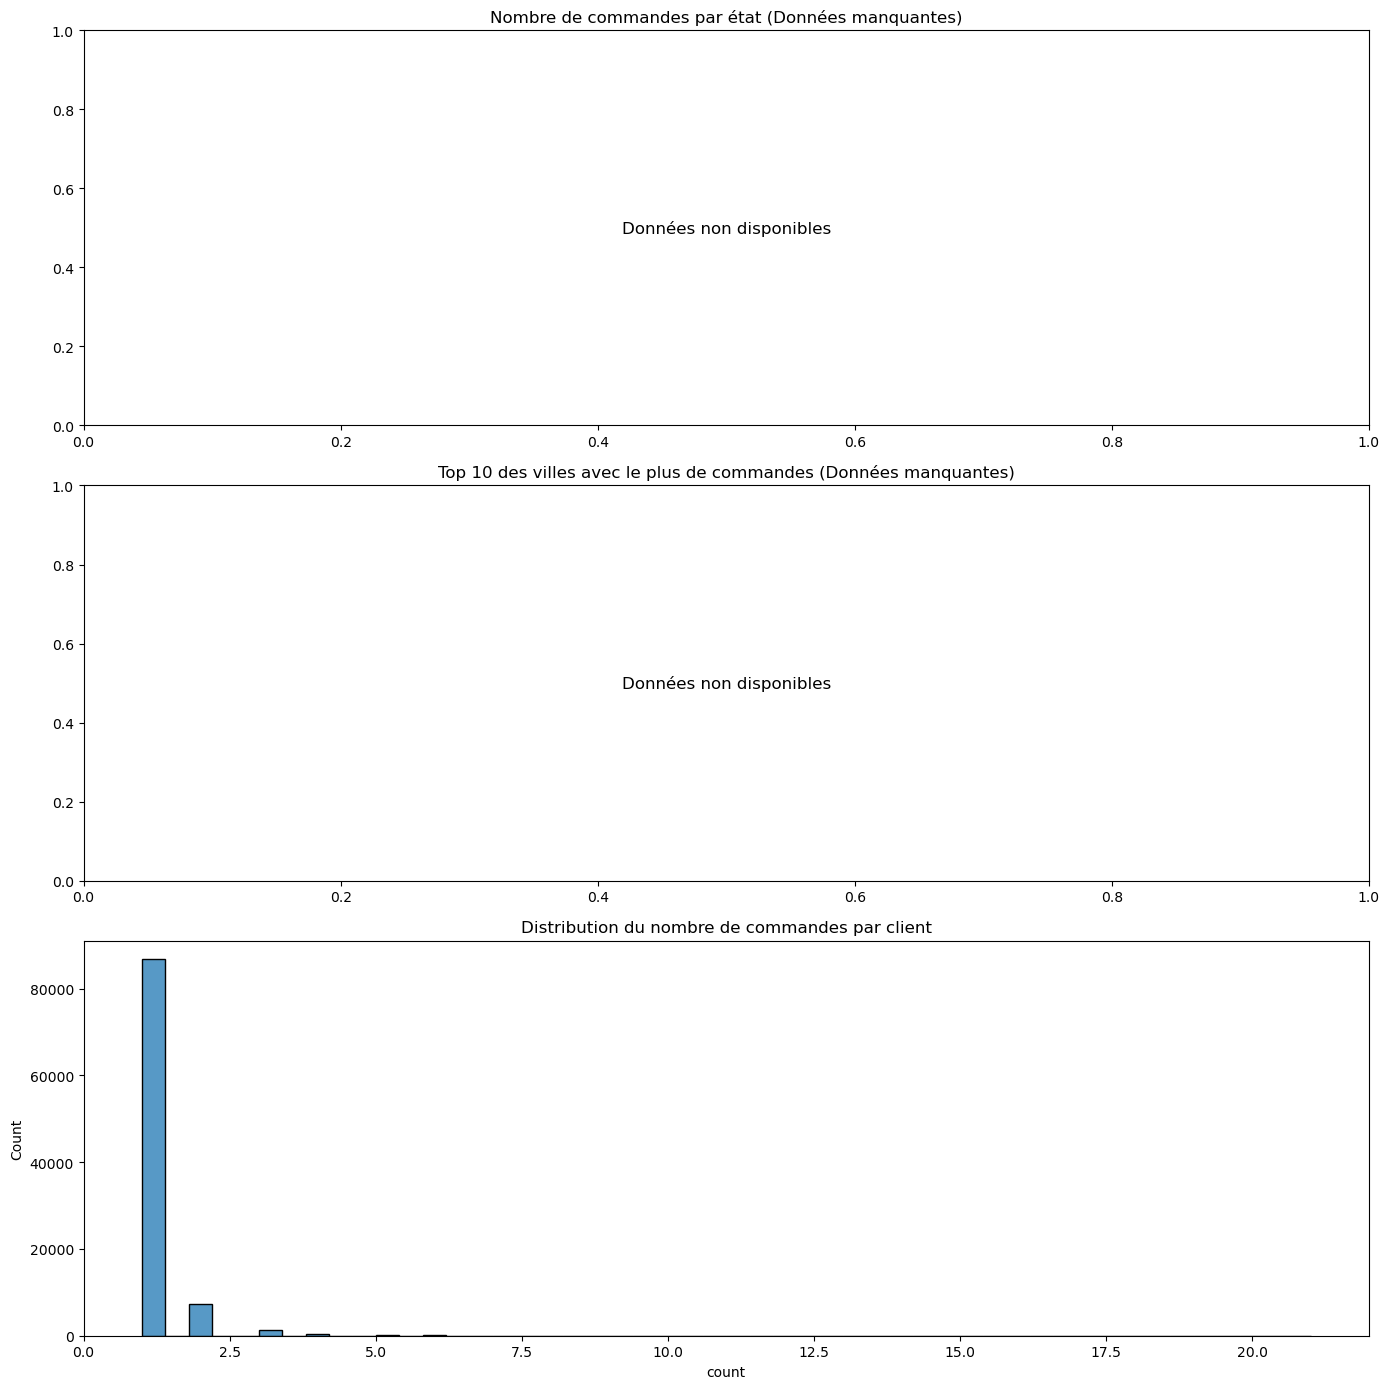

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(3, 1, figsize=(14, 14))

# Vérifier si la colonne 'cust_state' existe avant d'afficher le graphique
if 'cust_state' in ventes_df.columns:
    sns.countplot(x='cust_state', data=ventes_df, order=ventes_df['cust_state'].value_counts().index, ax=axes[0])
    axes[0].set_title("Nombre de commandes par état")
else:
    axes[0].text(0.5, 0.5, "Données non disponibles", ha='center', va='center', fontsize=12)
    axes[0].set_title("Nombre de commandes par état (Données manquantes)")

# Vérifier si la colonne 'cust_city' existe avant d'afficher le graphique
if 'cust_city' in ventes_df.columns:
    top_villes = ventes_df['cust_city'].value_counts().nlargest(10).index
    sns.countplot(x='cust_city', data=ventes_df[ventes_df['cust_city'].isin(top_villes)], ax=axes[1])
    axes[1].set_title("Top 10 des villes avec le plus de commandes")
    axes[1].tick_params(axis='x', rotation=45)  # Rotation des labels pour lisibilité
else:
    axes[1].text(0.5, 0.5, "Données non disponibles", ha='center', va='center', fontsize=12)
    axes[1].set_title("Top 10 des villes avec le plus de commandes (Données manquantes)")

# Vérifier si la colonne 'customer_id' existe avant d'afficher le graphique
if 'customer_id' in ventes_df.columns:
    sns.histplot(ventes_df['customer_id'].value_counts(), bins=50, ax=axes[2])
    axes[2].set_title("Distribution du nombre de commandes par client")
else:
    axes[2].text(0.5, 0.5, "Données non disponibles", ha='center', va='center', fontsize=12)
    axes[2].set_title("Distribution du nombre de commandes par client (Données manquantes)")

plt.tight_layout()
plt.show()


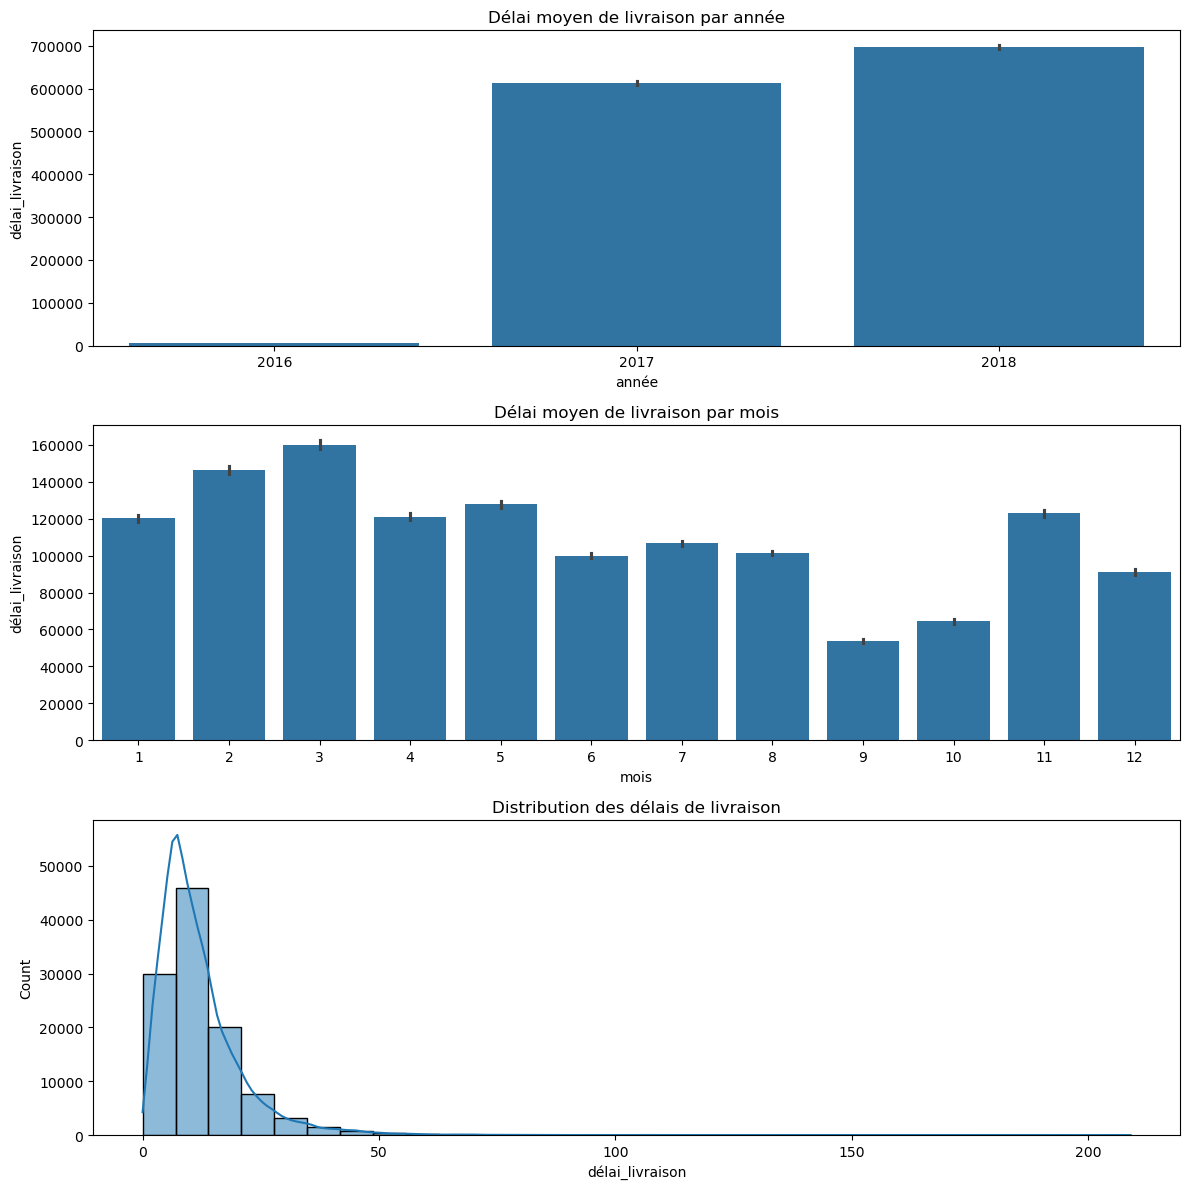

In [61]:
ventes_df['délai_livraison'] = (ventes_df['delivered_customer'] - ventes_df['purchase_timestamp']).dt.days

fig, axes = plt.subplots(3, 1, figsize=(12, 12))

# Délai moyen par année
sns.barplot(x='année', y='délai_livraison', data=ventes_df, estimator=sum, ax=axes[0])
axes[0].set_title("Délai moyen de livraison par année")

# Délai moyen par mois
sns.barplot(x='mois', y='délai_livraison', data=ventes_df, estimator=sum, ax=axes[1])
axes[1].set_title("Délai moyen de livraison par mois")

# Distribution des délais de livraison
sns.histplot(ventes_df['délai_livraison'], bins=30, kde=True, ax=axes[2])
axes[2].set_title("Distribution des délais de livraison")

plt.tight_layout()
plt.show()


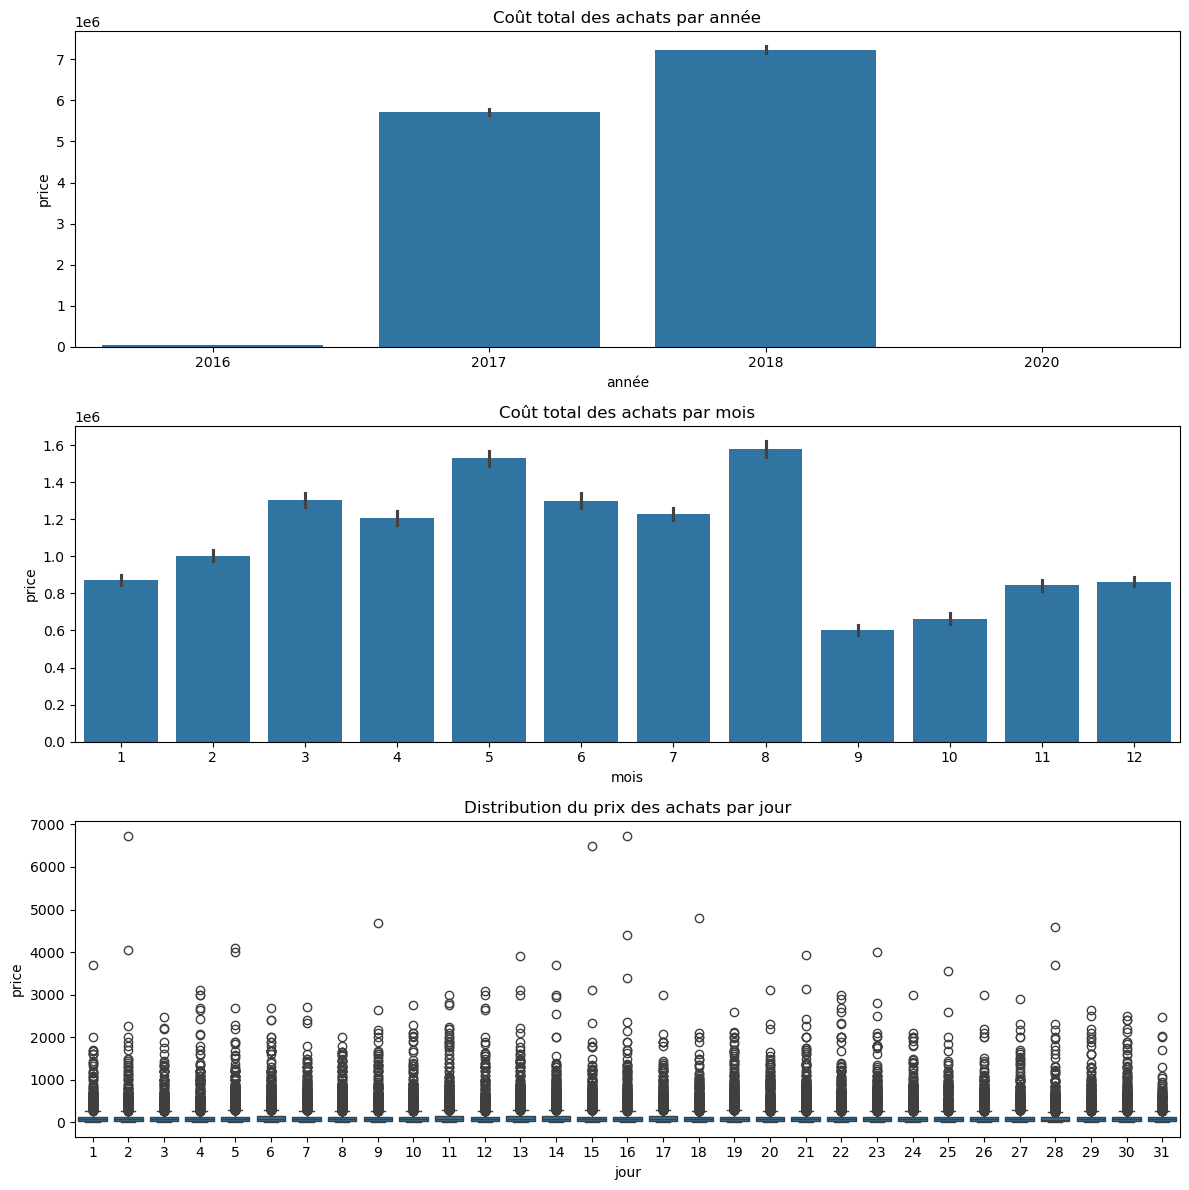

In [62]:
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

# Coût total par année
sns.barplot(x='année', y='price', data=achat_df, estimator=sum, ax=axes[0])
axes[0].set_title("Coût total des achats par année")

# Coût total par mois
sns.barplot(x='mois', y='price', data=achat_df, estimator=sum, ax=axes[1])
axes[1].set_title("Coût total des achats par mois")

# Répartition du prix des achats
sns.boxplot(x='jour', y='price', data=achat_df, ax=axes[2])
axes[2].set_title("Distribution du prix des achats par jour")

plt.tight_layout()
plt.show()


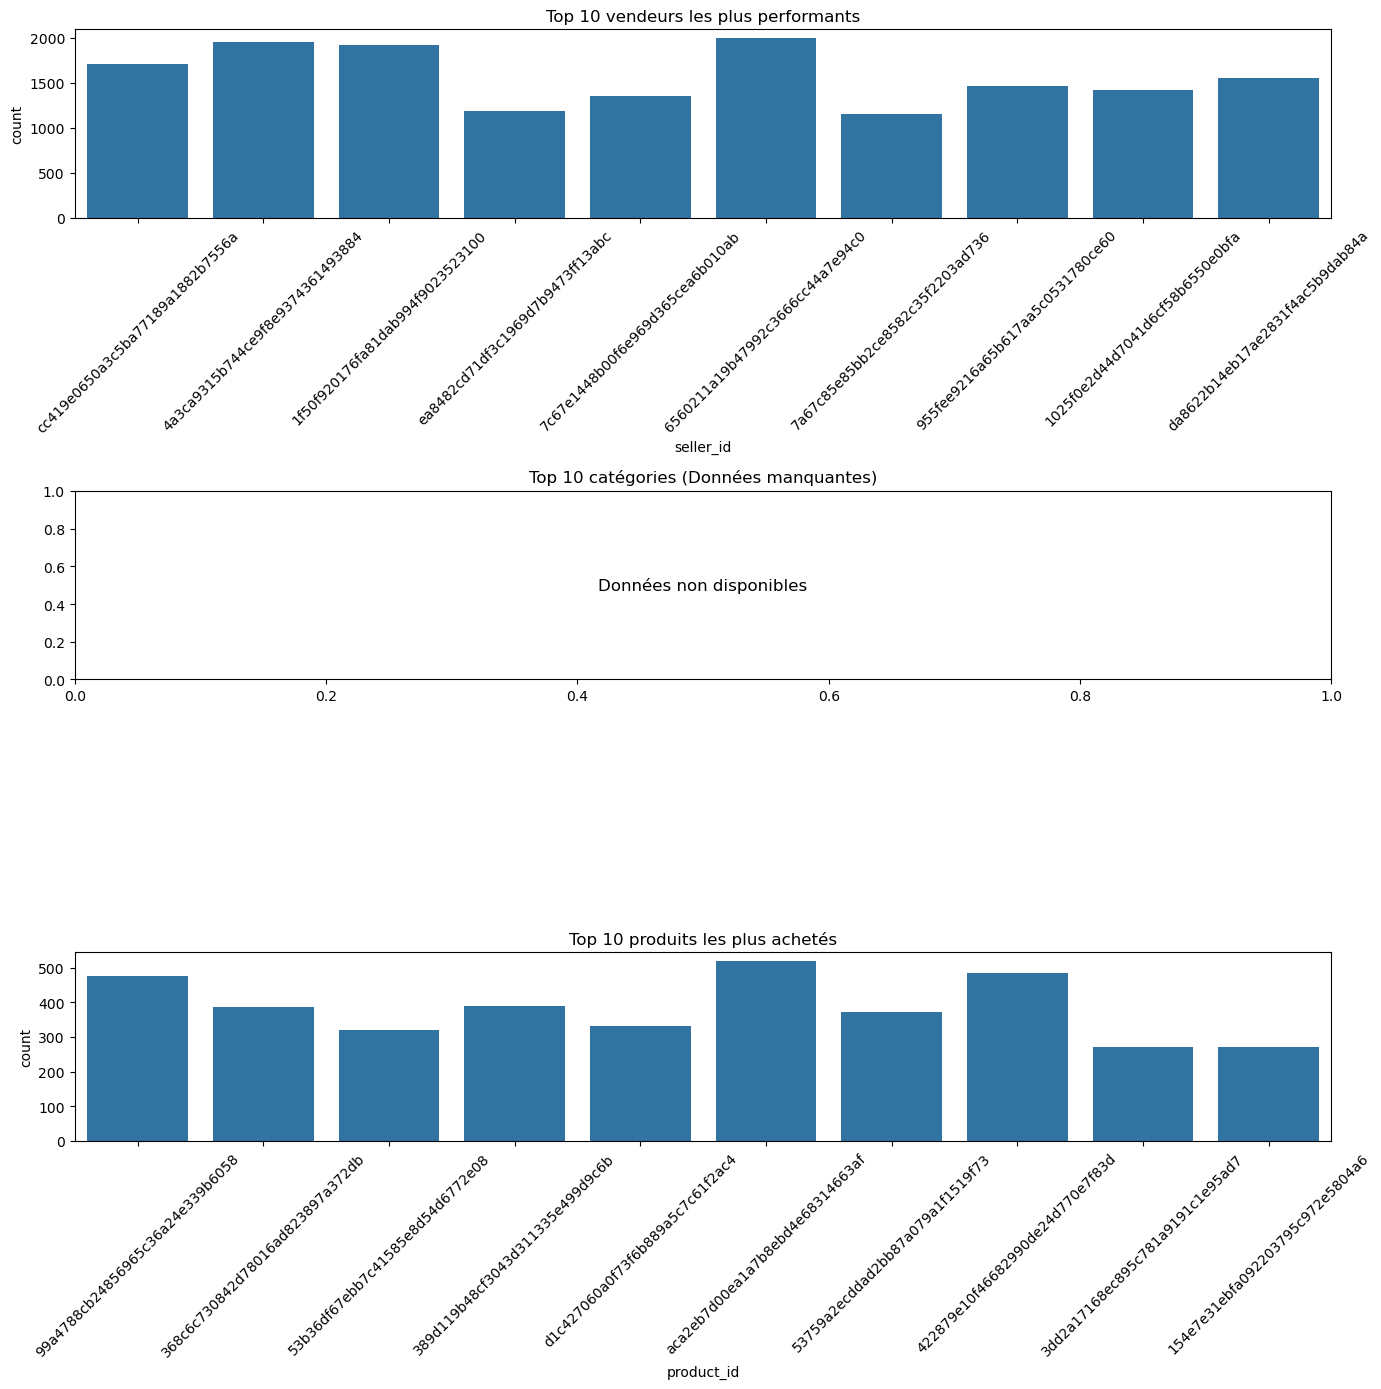

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(3, 1, figsize=(14, 14))

# Vérifier si 'seller_id' existe avant d'afficher le graphique des vendeurs les plus performants
if 'seller_id' in achat_df.columns:
    top_vendeurs = achat_df['seller_id'].value_counts().nlargest(10).index
    sns.countplot(x='seller_id', data=achat_df[achat_df['seller_id'].isin(top_vendeurs)], ax=axes[0])
    axes[0].set_title("Top 10 vendeurs les plus performants")
    axes[0].tick_params(axis='x', rotation=45)
else:
    axes[0].text(0.5, 0.5, "Données non disponibles", ha='center', va='center', fontsize=12)
    axes[0].set_title("Top 10 vendeurs (Données manquantes)")

# Vérifier si 'product_category' existe avant d'afficher le graphique des catégories
if 'product_category' in achat_df.columns:
    top_categories = achat_df['product_category'].value_counts().nlargest(10).index
    sns.countplot(x='product_category', data=achat_df[achat_df['product_category'].isin(top_categories)], ax=axes[1])
    axes[1].set_title("Top 10 catégories de produits achetés")
    axes[1].tick_params(axis='x', rotation=45)
else:
    axes[1].text(0.5, 0.5, "Données non disponibles", ha='center', va='center', fontsize=12)
    axes[1].set_title("Top 10 catégories (Données manquantes)")

# Vérifier si 'product_id' existe avant d'afficher le graphique des meilleurs produits
if 'product_id' in achat_df.columns:
    top_produits = achat_df['product_id'].value_counts().nlargest(10).index
    sns.countplot(x='product_id', data=achat_df[achat_df['product_id'].isin(top_produits)], ax=axes[2])
    axes[2].set_title("Top 10 produits les plus achetés")  # ✅ Correction ici
    axes[2].tick_params(axis='x', rotation=45)
else:
    axes[2].text(0.5, 0.5, "Données non disponibles", ha='center', va='center', fontsize=12)
    axes[2].set_title("Top 10 produits (Données manquantes)")

plt.tight_layout()
plt.show()


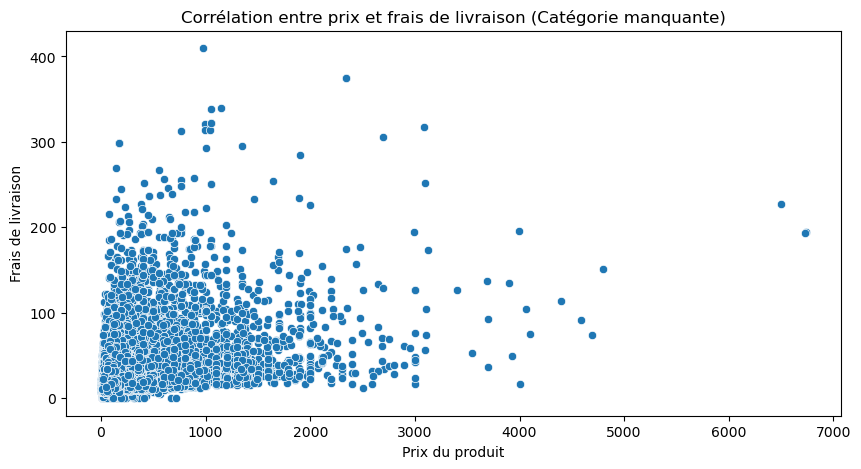

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))

# Vérifier si 'product_category' existe avant de l'utiliser
if 'product_category' in achat_df.columns:
    sns.scatterplot(x='price', y='freight_value', data=achat_df, hue='product_category')
    plt.title("Corrélation entre prix et frais de livraison par catégorie de produit")
else:
    sns.scatterplot(x='price', y='freight_value', data=achat_df)
    plt.title("Corrélation entre prix et frais de livraison (Catégorie manquante)")

plt.xlabel("Prix du produit")
plt.ylabel("Frais de livraison")
plt.show()
